STEP 1
Define the Imports.
Notice that we have put the RandomNo seed, lines right at the top, We want them to be always constant, so that we get similar results whenever we RE run the notebook.

In [1]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.set_random_seed(1)

import numpy as np
import scipy
import h5py
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.python.keras.optimizers import Adam,RMSprop 

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Flatten, Dense,Conv2D, MaxPooling2D,Dropout,BatchNormalization
from tensorflow.python.keras import backend as K
 

C:\Users\ali\Anaconda3\envs\tfgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


STEP 2
Define the Data Source. 
This may differ, and you should modify it to point to your correct paths

In [2]:
train_data_dir = 'C:\\data\\mnist_png\\train'
validation_data_dir = 'C:\\data\\mnist_png\\validation'
userCreatedImages_dir = "C:\\data\\mnist_png\\ProcessedUserData\\"

STEP 3
Initalize the Variables.
a) Size of the image ( remember its always square, our images are 28x28 pixels)
b) Number of images in Training and Validation directories.
c) EPOCHS (How many times do you want to repeat the training)
d) BATCHES: What size batch do we want to divide our Data 
e) num_classes:  how many output labels are there   ( we have 10 unique digits)

In [3]:
# Initialize the variables
image_width, image_height = 28, 28
nb_train_samples = 60000
nb_validation_samples = 10000
epochs =5
batch_size = 128
num_classes=10

STEP 4
This is where we pull the images from the directories.
As we get an image, we are doing multiple things here
a) we are dividing it by 255 ( normalization)
b) we are automatically resizing the image to our required image_width and image_height
c) we are pulling the defined batch quantity of images.
Note the use of class_mode = "categorical"  , this pulls the subdir names as labels for the images in it.

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./ 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


STEP 5
Here we define the Model
This is a deep network.
We are using Dropout , to avoid overfitting issues.
Note that the loss is "categorical_crossentropy"  


In [5]:
optimizer = RMSprop(lr=0.001,decay=1e-6)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(image_width, image_height, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3) ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)  ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3) ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,   activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes,   activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
__________

STEP 6
We run the model, training it, with the given data.
We collect a trace of its values after every run, in history.
we save the last model


In [6]:
with tf.device('/gpu:0'):
    history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples)        

model_json = model.to_json()
with open("model_mnist.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights('model_mnist.h5')
print("Saved model to disk")        

Epoch 1/5
468/468 [==============================] - 385s 822ms/step - loss: 0.3602 - acc: 0.8854 - val_loss: 0.0695 - val_acc: 0.9785
Epoch 2/5
468/468 [==============================] - 373s 797ms/step - loss: 0.1064 - acc: 0.9693 - val_loss: 0.0457 - val_acc: 0.9854
Epoch 3/5
468/468 [==============================] - 374s 799ms/step - loss: 0.0783 - acc: 0.9765 - val_loss: 0.0344 - val_acc: 0.9905
Epoch 4/5
468/468 [==============================] - 389s 832ms/step - loss: 0.0649 - acc: 0.9810 - val_loss: 0.0349 - val_acc: 0.9896
Epoch 5/5
468/468 [==============================] - 374s 800ms/step - loss: 0.0585 - acc: 0.9828 - val_loss: 0.0275 - val_acc: 0.9919
Saved model to disk


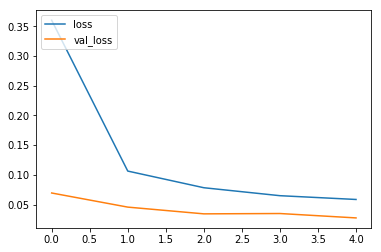

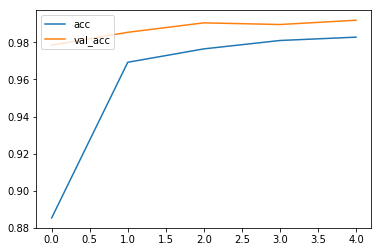

In [11]:
loss = history.history['loss']  
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss','val_loss'],loc='upper left')
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['acc','val_acc'],loc='upper left')
plt.show() 

Step 7  Here we use the above model, to predict the label of new images, we give it.

C:\data\mnist_png\ProcessedUserData\1a.png
[1]


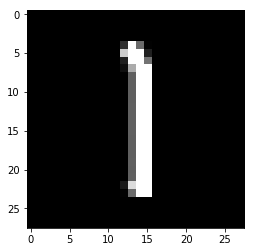

C:\data\mnist_png\ProcessedUserData\3a.bmp
[3]


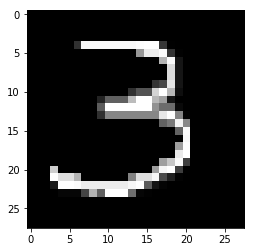

C:\data\mnist_png\ProcessedUserData\3b.bmp
[3]


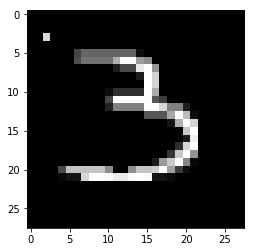

C:\data\mnist_png\ProcessedUserData\5a.bmp
[3]


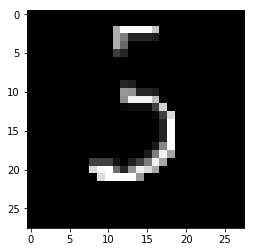

C:\data\mnist_png\ProcessedUserData\6a.bmp
[1]


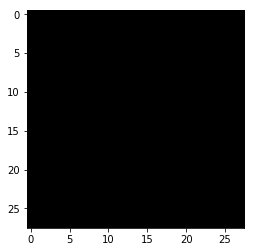

C:\data\mnist_png\ProcessedUserData\6b.bmp
[6]


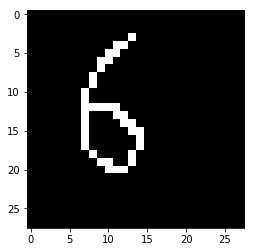

C:\data\mnist_png\ProcessedUserData\userdefined4.png
[4]


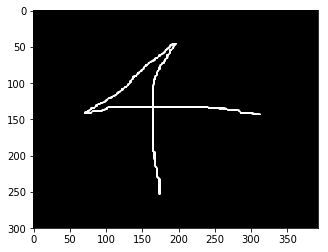

C:\data\mnist_png\ProcessedUserData\userdefineed7.png
[7]


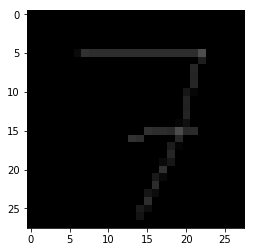

In [12]:
path = userCreatedImages_dir
files = os.listdir(path)

for file in files:
    pred=-1
    t_image= image.load_img(path + file )
    print(path + file )
    test_image = image.load_img(path + file, target_size=(image_height, image_width))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
 
    predictions = model.predict_classes(test_image)
    print(predictions)
    plt.imshow(t_image)
    plt.show()      

In [9]:
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty


def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

In [10]:
import cv2
import math
from scipy import ndimage
path = "C:\\data\\mnist_png\\UserData\\"
processedPath ="C:\\data\\mnist_png\\ProcessedUserData\\" 
files = os.listdir(path)

for file in files:
    t_image= path+file
   
    if (os.path.isdir(t_image)):  
        print("Directory")
        continue
    
    gray = cv2.imread(t_image,0)
    gray = cv2.resize(255-gray, (28, 28))
    
    (thresh,gray)= cv2.threshold(gray,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols,rows))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        # first cols than rows
        gray = cv2.resize(gray, (cols, rows))

    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    gray = shifted
     # save the processed images
    print(processedPath+file)
    cv2.imwrite(processedPath+file, gray)

C:\data\mnist_png\ProcessedUserData\1a.png
C:\data\mnist_png\ProcessedUserData\3a.bmp
C:\data\mnist_png\ProcessedUserData\3b.bmp
C:\data\mnist_png\ProcessedUserData\5a.bmp
